In [12]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# Import K's code for calculating the coefficients of the carb system
import calc_coeffs as co2
import H_poly as hpoly
import H_poly2 as hpoly2
from importlib import reload
import warnings
# warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

In [13]:
%cd /Users/akbaskind/Documents/Python Scripts/OCG577

/Users/akbaskind/Documents/Python Scripts/OCG577


In [14]:
import carbon as carbon

In [19]:
T = np.arange(19,23,0.1)
S = np.zeros(len(T))
S[:] = 33.464
carbon.density_1atm(T,S)


array([1023.32384296, 1023.29853504, 1023.2731411 , 1023.24766129,
       1023.22209576, 1023.19644465, 1023.1707081 , 1023.14488626,
       1023.11897928, 1023.09298729, 1023.06691044, 1023.04074887,
       1023.01450273, 1022.98817214, 1022.96175726, 1022.93525821,
       1022.90867515, 1022.8820082 , 1022.8552575 , 1022.82842319,
       1022.80150541, 1022.77450429, 1022.74741996, 1022.72025255,
       1022.69300221, 1022.66566906, 1022.63825324, 1022.61075488,
       1022.5831741 , 1022.55551104, 1022.52776583, 1022.4999386 ,
       1022.47202948, 1022.44403859, 1022.41596606, 1022.38781202,
       1022.3595766 , 1022.33125992, 1022.30286211, 1022.27438329])

# Open GLODAP data & process

In [4]:
# Read in 
dat = pd.read_csv('/Users/akbaskind/Desktop/GLODAPv2.2022_Indian_Ocean.csv')
## Remove bad data
# Remove negative TCO2 and TAlk and oxygen and salinity and CFCs
dat = dat.where(dat['G2tco2'] > 0).dropna()
dat = dat.where(dat['G2talk'] > 0).dropna()
dat = dat.where(dat['G2oxygen'] > 0).dropna()
dat = dat.where(dat['G2salinity'] > 0).dropna()
dat = dat.where(dat['G2pcfc12'] > 0).dropna()
dat = dat.where(dat['G2pcfc11'] > 0).dropna()
# Remove temperatures less than -100°C
dat = dat.where(dat['G2temperature'] > -100).dropna()
# Remove flagged and negative phosphate
dat = dat.where(dat['G2phosphatef'] != 9).dropna()
dat = dat.where(dat['G2phosphate'] >= 0).dropna()
# Select data we want
dat = dat[['G2depth', 'G2latitude', 'G2longitude', 'G2year', 'G2tco2', 'G2talk', 'G2oxygen', 'G2temperature', 'G2salinity',
          'G2phosphate','G2pcfc12', 'G2pcfc11','G2fco2']]
# list(dat.keys())
dat

,G2depth,G2latitude,G2longitude,G2year,G2tco2,G2talk,G2oxygen,G2temperature,G2salinity,G2phosphate,G2pcfc12,G2pcfc11,G2fco2
592,52.0,-61.9840,120.0300,1994.0,2170.2,2304.3,350.8,-1.3240,33.9660,1.86,451.020000,226.380000,808.680000
593,103.0,-61.9840,120.0300,1994.0,2196.1,2315.8,301.3,-0.9550,34.1510,2.03,346.500000,172.380000,902.650000
594,202.0,-61.9840,120.0300,1994.0,2254.5,2340.3,179.1,1.8240,34.6190,2.31,51.754000,27.811000,1176.300000
595,299.0,-61.9840,120.0300,1994.0,2255.4,2343.6,180.6,1.9040,34.6770,2.22,30.033000,15.764000,1159.700000
597,597.0,-61.9840,120.0300,1994.0,2247.0,2352.7,191.9,1.7660,34.7310,2.13,22.301000,10.693000,1033.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167708,4017.0,-20.0001,80.0002,2019.0,2298.0,2402.3,183.9,1.3652,34.7183,2.30,0.654891,0.604255,1080.317428
167709,4264.0,-20.0001,80.0002,2019.0,2301.8,2404.9,183.5,1.3714,34.7178,2.30,0.817592,0.724082,1090.897354
167710,4504.0,-20.0001,80.0002,2019.0,2299.5,2407.2,183.4,1.3907,34.7174,2.31,0.817148,0.763840,1059.283577
167711,4747.0,-20.0001,80.0002,2019.0,2300.5,2406.0,183.4,1.4169,34.7169,2.31,0.980356,0.884221,1074.243117


## Rename columns, maybe reindex by lat-lon

In [5]:
dat = dat.rename(columns = {'G2depth': 'depth',
                            'G2latitude': 'latitude',
                            'G2longitude': 'longitude',
                            'G2year': 'year',
                            'G2tco2': 'DIC',
                            'G2talk': 'TA',
                            'G2oxygen': 'O2',
                            'G2temperature': 'temperature',
                            'G2salinity': 'salinity',
                            'G2phosphate': 'PO4',
                            'G2pcfc12': 'CFC12',
                            'G2pcfc11': 'CFC11',
                            'G2fco2': 'fCO2',
                            'G2chla': 'CHL'})
# dat.set_index(['latitude', 'longitude', 'depth'], inplace=True)
dat = dat.reset_index()
dat

,index,depth,latitude,longitude,year,DIC,TA,O2,temperature,salinity,PO4,CFC12,CFC11,fCO2
0,592,52.0,-61.9840,120.0300,1994.0,2170.2,2304.3,350.8,-1.3240,33.9660,1.86,451.020000,226.380000,808.680000
1,593,103.0,-61.9840,120.0300,1994.0,2196.1,2315.8,301.3,-0.9550,34.1510,2.03,346.500000,172.380000,902.650000
2,594,202.0,-61.9840,120.0300,1994.0,2254.5,2340.3,179.1,1.8240,34.6190,2.31,51.754000,27.811000,1176.300000
3,595,299.0,-61.9840,120.0300,1994.0,2255.4,2343.6,180.6,1.9040,34.6770,2.22,30.033000,15.764000,1159.700000
4,597,597.0,-61.9840,120.0300,1994.0,2247.0,2352.7,191.9,1.7660,34.7310,2.13,22.301000,10.693000,1033.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37316,167708,4017.0,-20.0001,80.0002,2019.0,2298.0,2402.3,183.9,1.3652,34.7183,2.30,0.654891,0.604255,1080.317428
37317,167709,4264.0,-20.0001,80.0002,2019.0,2301.8,2404.9,183.5,1.3714,34.7178,2.30,0.817592,0.724082,1090.897354
37318,167710,4504.0,-20.0001,80.0002,2019.0,2299.5,2407.2,183.4,1.3907,34.7174,2.31,0.817148,0.763840,1059.283577
37319,167711,4747.0,-20.0001,80.0002,2019.0,2300.5,2406.0,183.4,1.4169,34.7169,2.31,0.980356,0.884221,1074.243117


# Surface data

In [6]:
surf = dat.where(dat['depth'] <= 2.5).dropna()
surf


,index,depth,latitude,longitude,year,DIC,TA,O2,temperature,salinity,PO4,CFC12,CFC11,fCO2
3618,20124.0,2.0,-65.5740,139.6600,2008.0,2180.6,2306.6,338.19,-1.8631,34.0230,1.9497,435.940000,202.370000,857.030000
6446,45307.0,2.0,3.0010,80.0010,1995.0,1921.0,2270.9,195.80,29.5900,34.7010,0.1300,548.550000,281.630000,246.581868
6461,45451.0,2.0,1.6670,80.0000,1995.0,1911.9,2257.1,196.50,29.5990,34.4970,0.1100,537.680000,275.530000,247.220656
6463,45667.0,2.0,0.0000,80.0020,1995.0,1901.9,2250.3,196.10,29.4830,34.3260,0.0900,543.320000,274.790000,240.783846
6464,45955.0,2.0,-2.3330,80.0000,1995.0,1901.3,2284.0,199.30,29.5900,34.3630,0.1100,550.800000,277.930000,213.193798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23428,109651.0,2.0,-65.6780,30.0140,1996.0,2151.7,2298.2,338.10,0.0594,33.8660,1.6393,469.430000,241.320000,741.530000
23467,109695.0,2.0,-66.3370,30.0030,1996.0,2145.8,2293.2,344.00,-0.6570,33.7810,1.8333,456.530000,231.390000,733.550000
25193,141355.0,2.0,-63.0030,82.0100,2016.0,2161.6,2288.8,337.40,1.2137,33.8130,1.6800,473.170000,217.140000,832.520000
25707,142232.0,1.0,-51.0370,89.3500,2016.0,2114.6,2273.2,299.30,6.6473,33.8000,1.3800,500.720000,225.210000,667.880000


# Pump calculations

## From PO$_4$

$$
\Delta \text{X} = \text{sX} - \text{sX}^{\text{ref}}
$$

$$
\Delta \text{DIC} ^{\text{soft}} = r_{\text{C:P}} \Delta \text{PO}_4
$$

$$
\Delta \text{Alk} ^{\text{soft}} = -r_{\text{N:C}} \Delta \text{DIC} ^{\text{soft}}
$$

$$
\Delta \text{Alk} ^{\text{carb}} = \Delta \text{Alk} - \Delta \text{Alk}^{\text{soft}}
$$

$$
\Delta \text{DIC} ^{\text{carb}} = 0.5\Delta \text{Alk} ^{\text{carb}}
$$

$$
\Delta \text{DIC} ^{\text{gas}} = \Delta \text{DIC} - \Delta \text{DIC} ^{\text{carb}} - \Delta \text{DIC} ^{\text{soft}} - \text{C}_{\text{ant}}
$$

$$
\text{C}_{\text{ant}}^{z} = \text{C}_{\text{ant}}^{z = 0} e^{-0.003z}
$$


$$
\Delta \text{Alk} ^{\text{gas}} = -r_{\text{N+P:O}_2} \Delta \text{DIC} ^{\text{gas}}
$$

## From O$_2$

O$_{2\ \text{saturation}}$ calculated according to Garcia, H. E., & Gordon, L. I. (1992). Oxygen solubility in seawater: Better fitting equations. Limnology and oceanography, 37(6), 1307-1312.

$$
\text{AOU} = [\text{O}_2]_{\text{saturation}} - [\text{O}_2]_{\text{observed}}
$$

$$
\Delta \text{DIC} ^{\text{soft}} = r_{\text{C:O}_2} \text{AOU}
$$

$$
\Delta \text{Alk} ^{\text{soft}} = -r_{\text{N+P:O}_2} \text{AOU}
$$

$$
\Delta \text{Alk} ^{\text{carb}} = \Delta \text{Alk} - \Delta \text{Alk}^{\text{soft}}
$$

$$
\Delta \text{DIC} ^{\text{carb}} = 0.5\Delta \text{Alk} ^{\text{carb}}
$$

$$
\Delta \text{DIC} ^{\text{gas}} = \Delta \text{DIC} - \Delta \text{DIC} ^{\text{carb}} - \Delta \text{DIC} ^{\text{soft}} - \text{C}_{\text{ant}}
$$

$$
\Delta \text{Alk} ^{\text{gas}} = -r_{\text{N+P:O}_2} \Delta \text{DIC} ^{\text{gas}}
$$

$$
\text{C}_{\text{ant}}^{z} = \text{C}_{\text{ant}}^{z = 0} e^{-0.003z}
$$

# Reference values
For S$_{\text{ref}}$, DIC$_{\text{ref}}$, TA$_{\text{ref}}$, and PO$_{4\ \text{ref}}$, I am using the surface mean. I have defined "surface" to be above 50 m.

In [11]:
surf['DIC']

3618     2180.6
6446     1921.0
6461     1911.9
6463     1901.9
6464     1901.3
          ...  
23428    2151.7
23467    2145.8
25193    2161.6
25707    2114.6
32822    1986.2
Name: DIC, Length: 90, dtype: float64

In [7]:
Sref = surf['salinity'].mean()
DICref = surf['DIC'].quantile(0.5)
TAref = surf['TA'].quantile(0.5)
T = dat['temperature']
S = dat['salinity']
DIC = dat['DIC']
TA = dat['TA']
O2 = dat['O2']
PO4 = dat['PO4']
CFC12 = dat['CFC12']
CFC12ref = 5.9
t = dat['year']
PO4ref = surf['PO4'].mean()
Z = dat['depth']
results = carbon.solver(DIC = DIC, temperature = T, salinity = S, 
              TA = TA, PO4 = PO4, Sref = Sref, Alkref = TAref,
            DICref = DICref, z = Z, PO4ref = PO4ref, t = t, 
                       CFC12 = CFC12, CFC12ref = CFC12ref, O2 = O2)
results.keys()

dict_keys(['[H+]', 'pH', '[HCO3]', '[CO3]', '[CO2*]', 'pCO2', 'DIC', 'TA', 'k0', 'k1', 'k2', 'kw', 'kb', 'BT', 'OH', 'BOH4', 'OmegaAr', 'KAr', 'Revelle Factor', 'S_ref', 'sDIC', 'sDIC_ref', 'sAlk', 'sAlk_ref', 'C_ant', '∆C_soft', '∆TA_soft', '∆C_carb', '∆TA_carb', '∆C_gasex', '∆TA_gasex', 'sPO4', 'sPO4ref', '∆PO4', 'dDIC', 'G', 'Cant0'])

# Add pump info to data

In [8]:
dat['pCO2'] = results['pCO2']
dat['pH'] = results['pH']
dat['∆Ccarb'] = results['∆C_carb']
dat['∆Csoft'] = results['∆C_soft']
dat['∆Cgas'] = results['∆C_gasex']
dat['∆PO4'] = results['∆PO4']
dat['Cant0'] = results['Cant0']
dat['Cant'] = results['C_ant']
dat['sDIC'] = results['sDIC']
dat['sDICref'] = results['sDIC_ref']
dat['sAlkref'] = results['sAlk_ref']
dat['dDIC'] = results['dDIC']
dat['G'] = results['G']
dat

,index,depth,latitude,longitude,year,DIC,TA,O2,temperature,salinity,...,∆Csoft,∆Cgas,∆PO4,Cant0,Cant,sDIC,sDICref,sAlkref,dDIC,G
0,592,52.0,-61.9840,120.0300,1994.0,2170.2,2304.3,350.8,-1.3240,33.9660,...,194.597196,-65.902096,1.663224,52.925775,91.951399,2187.699098,1909.9,2236.85,277.799098,1.737365
1,593,103.0,-61.9840,120.0300,1994.0,2196.1,2315.8,301.3,-0.9550,34.1510,...,213.484805,-51.196405,1.824656,53.664900,71.628998,2201.815480,1909.9,2236.85,291.915480,1.334746
2,594,202.0,-61.9840,120.0300,1994.0,2254.5,2340.3,179.1,1.8240,34.6190,...,243.000030,8.881283,2.076923,57.508328,11.464892,2229.810493,1909.9,2236.85,319.910493,0.199361
3,595,299.0,-61.9840,120.0300,1994.0,2255.4,2343.6,180.6,1.9040,34.6770,...,232.196329,22.724137,1.984584,57.708592,6.676279,2226.969615,1909.9,2236.85,317.069615,0.115690
4,597,597.0,-61.9840,120.0300,1994.0,2247.0,2352.7,191.9,1.7660,34.7310,...,221.454210,21.537146,1.892771,57.684141,4.955370,2215.225889,1909.9,2236.85,305.325889,0.085905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37316,167708,4017.0,-20.0001,80.0002,2019.0,2298.0,2402.3,183.9,1.3652,34.7183,...,241.151133,31.497581,2.061121,57.257448,0.092109,2266.333439,1909.9,2236.85,356.433439,0.001609
37317,167709,4264.0,-20.0001,80.0002,2019.0,2301.8,2404.9,183.5,1.3714,34.7178,...,241.154606,33.952128,2.061150,57.262106,0.115001,2270.113768,1909.9,2236.85,360.213768,0.002008
37318,167710,4504.0,-20.0001,80.0002,2019.0,2299.5,2407.2,183.4,1.3907,34.7174,...,242.311291,29.321371,2.071037,57.284895,0.114985,2267.871559,1909.9,2236.85,357.971559,0.002007
37319,167711,4747.0,-20.0001,80.0002,2019.0,2300.5,2406.0,183.4,1.4169,34.7169,...,242.314781,30.888178,2.071067,57.311965,0.138016,2268.890481,1909.9,2236.85,358.990481,0.002408


In [9]:
pink = '#ff6289'
purple = '#C79FEF'
blue = '#82e9ff'
green = '#C1F80A'

# Greens
caribbean_green = '#00cc99'
emerald = '#319177'
crayola_green = '#1cac78'
jade = '#00a86b'
kelly = '#4cbb17'
yellowgreen = '#9acd32'

# Blues
french_sky_blue = '#77b5fe'
opal = '#a8c3bc'
baby_blue = '#89cff0'
tiffany_blue = '#0abab5'
cornflower = '#6495ed'

# Pinks
hollywood_cerise = '#f400a1'
baker_miller = '#ff91af'
wild_strawberry = '#ff43a4'

# Purples
iris = '#5a4fcf'
orchid = '#9932cc'
amethyst = '#9966cc'
wisteria = '#c9a0dc'

# Oranges
neon_carrot = '#ffa343'
gamboge = '#e49b0f'
carrot = '#ed9121'

# Yellows
sunglow = '#ffcc33'
bitter_lemon = '#cae00d'
pantone_yellow = '#fedf00'

# Reds
candy_apple = '#e2062c'
carmine = '#eb4c42'
coquelicot = '#ff3800'

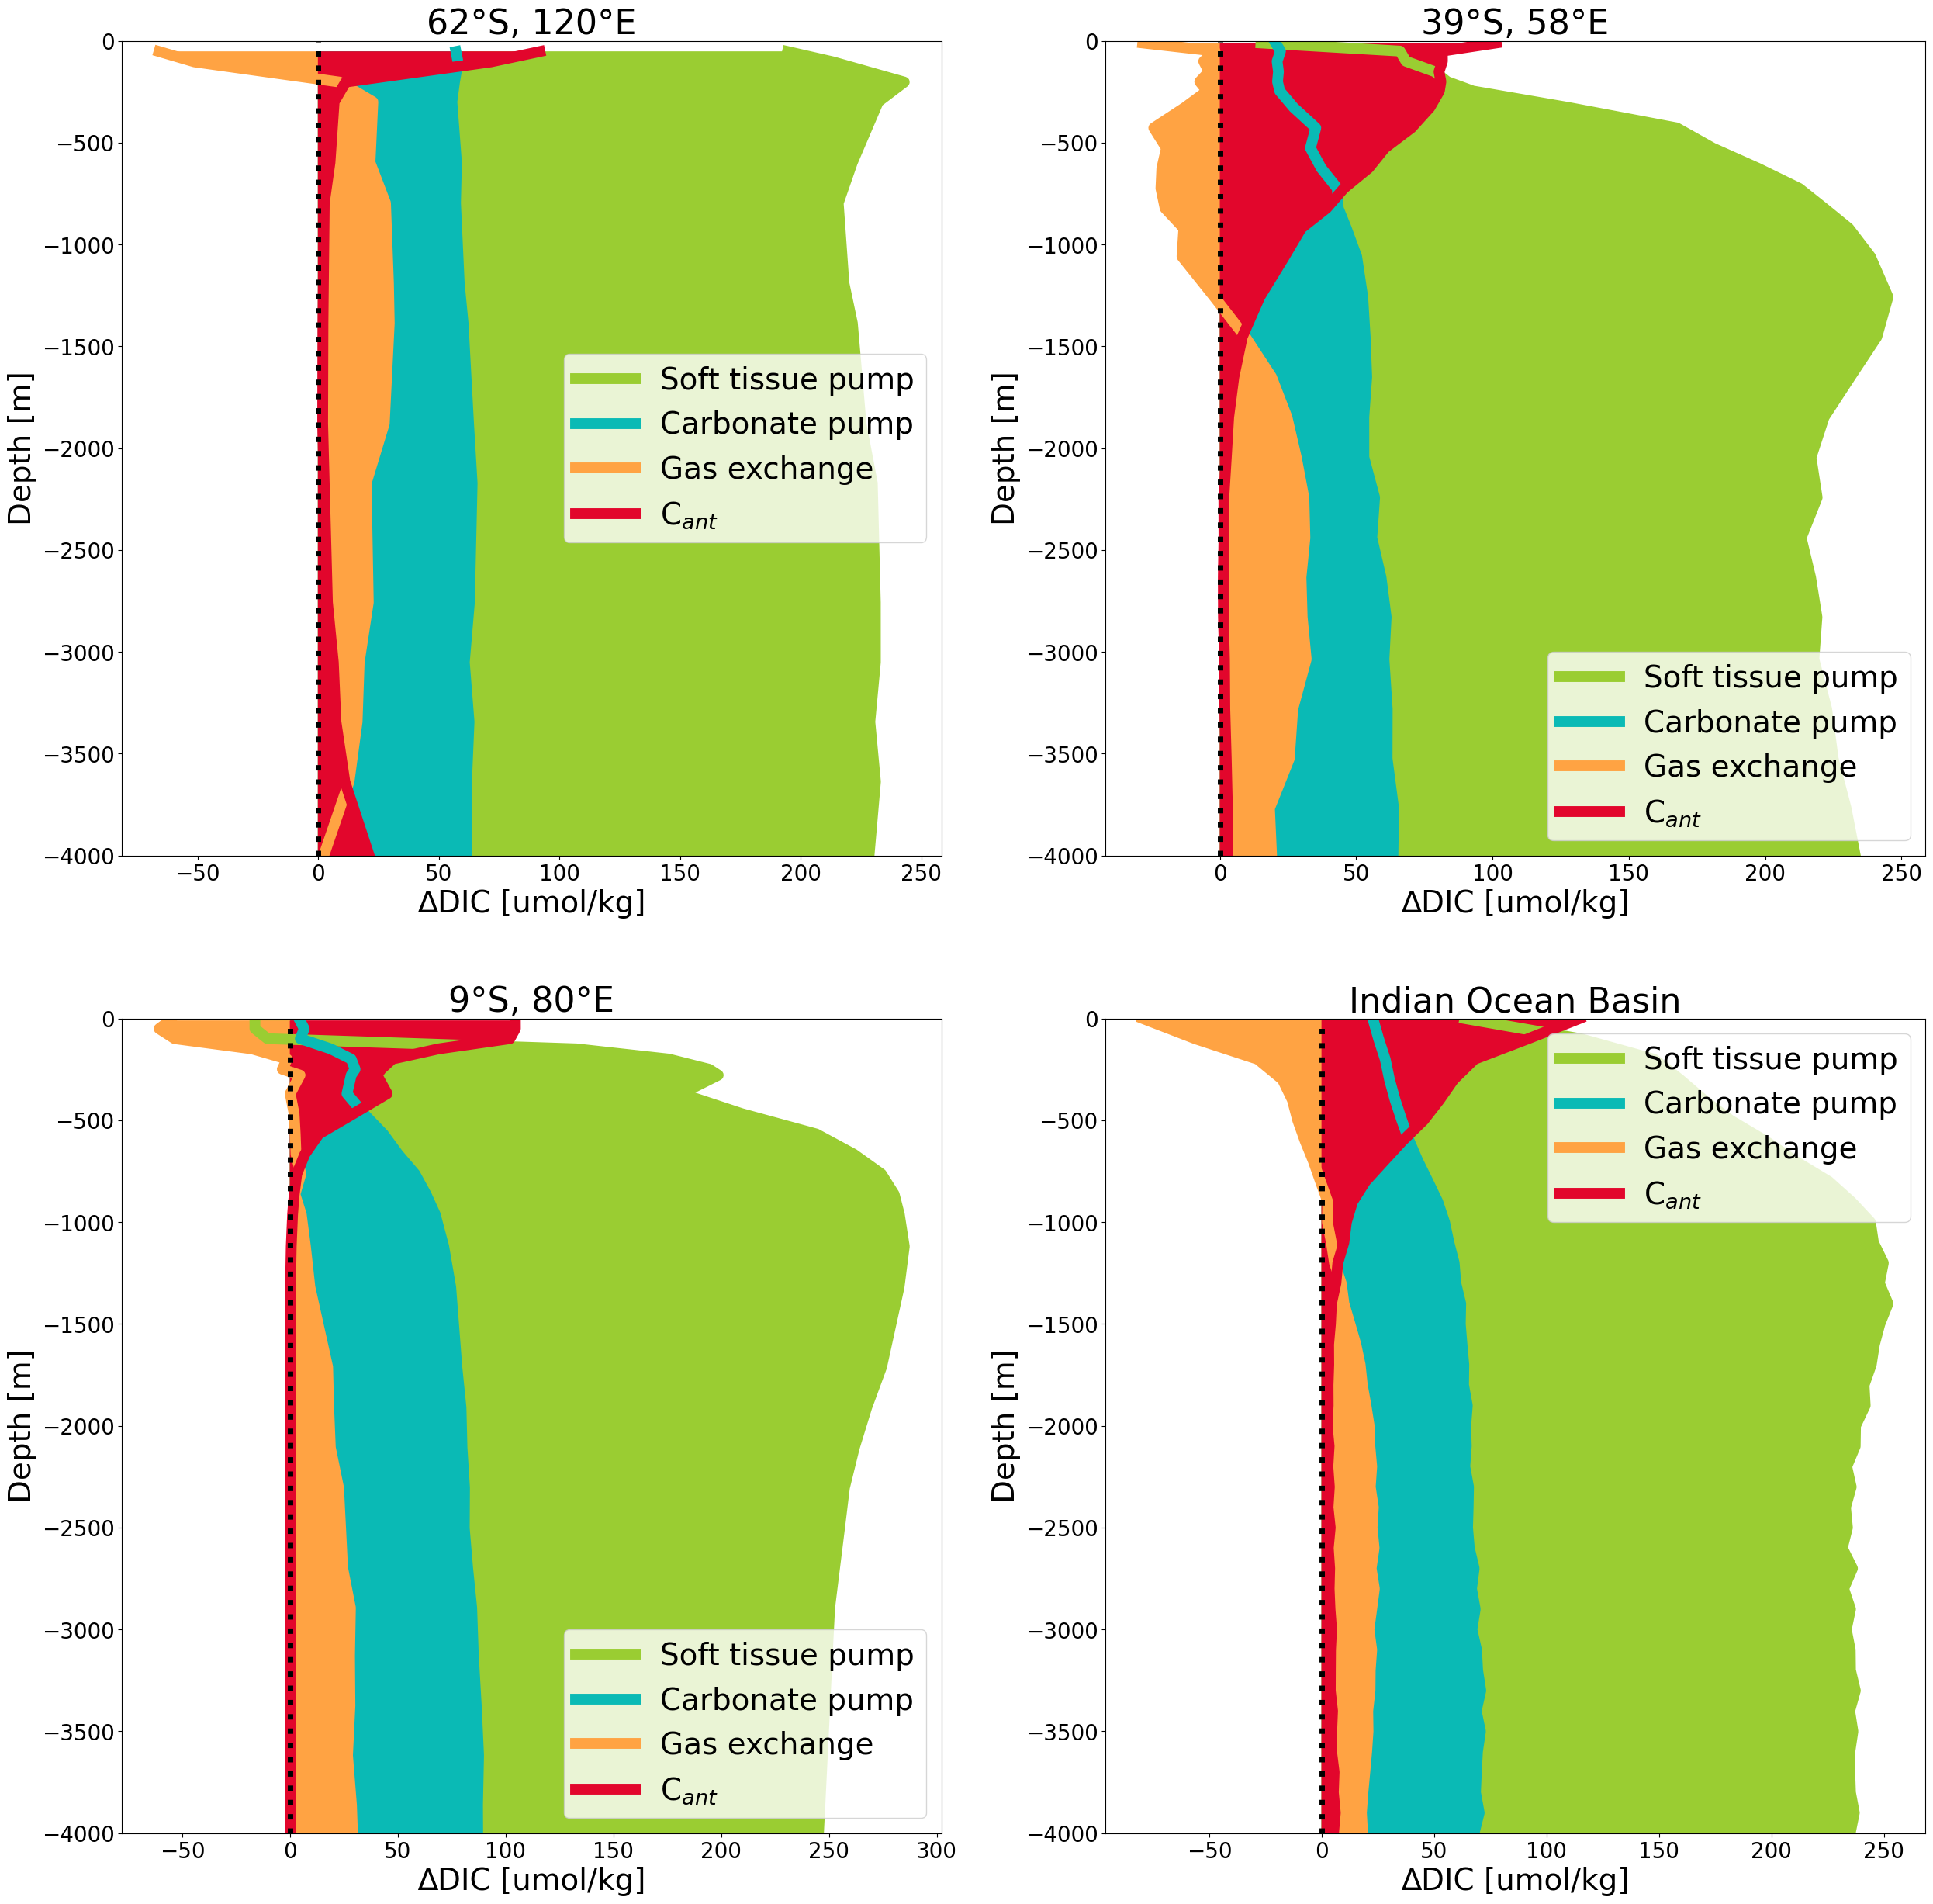

In [10]:
fig, axarr = plt.subplots(ncols = 2, nrows = 2, figsize = [30,30])
axarr = axarr.flatten()
TS = 32
LS = 28
LW = 10

# Three sites and mean
# first site
ax = axarr[0]
one = dat.where(dat['latitude'] == -61.9840).where(dat['longitude'] == 120.0300).dropna()
carb = one['∆Ccarb']
soft = one['∆Csoft'] 
cant = one['Cant']
gas = one['∆Cgas']
Z = one['depth']
ax.plot(soft, -Z, lw = LW, color = yellowgreen, label = 'Soft tissue pump')
ax.fill_betweenx(-Z, soft, 0, color = yellowgreen)
ax.plot(carb, -Z, lw = LW, color = tiffany_blue, label = 'Carbonate pump')
ax.fill_betweenx(-Z, carb, 0, color = tiffany_blue)
ax.plot(gas, -Z, lw = LW, color = neon_carrot, label = 'Gas exchange')
ax.fill_betweenx(-Z, gas, 0, color = neon_carrot)
ax.plot(cant, -Z, lw = LW, color = candy_apple, label = 'C$_{ant}$')
ax.fill_betweenx(-Z, cant, 0, color = candy_apple)
ax.set_title('62°S, 120°E', fontsize = TS)
ax.set_xlabel('∆carbon [umol/kg]', fontsize = LS)
ax.set_ylabel('depth [m]', fontsize = LS)
ax.legend(fontsize = LS)

# second site
ax = axarr[1]
# (-36.0, 30.0)
one = dat.where(dat['latitude'] == -39.2456).where(dat['longitude'] == 57.6915).dropna()
carb = one['∆Ccarb']
soft = one['∆Csoft'] 
cant = one['Cant']
gas = one['∆Cgas']
Z = one['depth']
ax.plot(soft, -Z, lw = LW, color = yellowgreen, label = 'Soft tissue pump')
ax.fill_betweenx(-Z, soft, 0, color = yellowgreen)
ax.plot(carb, -Z, lw = LW, color = tiffany_blue, label = 'Carbonate pump')
ax.fill_betweenx(-Z, carb, 0, color = tiffany_blue)
ax.plot(gas, -Z, lw = LW, color = neon_carrot, label = 'Gas exchange')
ax.fill_betweenx(-Z, gas, 0, color = neon_carrot)
ax.plot(cant, -Z, lw = LW, color = candy_apple, label = 'C$_{ant}$')
ax.fill_betweenx(-Z, cant, 0, color = candy_apple)
ax.set_title('39°S, 58°E', fontsize = TS)


# second site
ax = axarr[2]
one = dat.where(dat['latitude'] == -9.0004).where(dat['longitude'] == 79.9991).dropna()
carb = one['∆Ccarb']
soft = one['∆Csoft'] 
cant = one['Cant']
gas = one['∆Cgas'] 
Z = one['depth']
ax.plot(soft, -Z, lw = LW, color = yellowgreen, label = 'Soft tissue pump')
ax.fill_betweenx(-Z, soft, 0, color = yellowgreen)
ax.plot(carb, -Z, lw = LW, color = tiffany_blue, label = 'Carbonate pump')
ax.fill_betweenx(-Z, carb, 0, color = tiffany_blue)
ax.plot(gas, -Z, lw = LW, color = neon_carrot, label = 'Gas exchange')
ax.fill_betweenx(-Z, gas, 0, color = neon_carrot)
ax.plot(cant, -Z, lw = LW, color = candy_apple, label = 'C$_{ant}$')
ax.fill_betweenx(-Z, cant, 0, color = candy_apple)

ax.set_title('9°S, 80°E', fontsize = TS)


# first site
ax = axarr[3]
datdepth = dat.copy()
datdepth['depth'] = round(datdepth['depth'],-2)
datdepth = datdepth.groupby(['depth']).mean()
carb = datdepth['∆Ccarb']
soft = datdepth['∆Csoft'] 
cant = datdepth['Cant']
gas = datdepth['∆Cgas']
# Z = one['depth']
# carb = datdepth['∆Ccarb']
# soft = datdepth['∆Csoft']
# gas = datdepth['∆Cgas']
# cant = datdepth['Cant']
Z = datdepth.index
ax.plot(soft, -Z, lw = LW, color = yellowgreen, label = 'Soft tissue pump')
ax.fill_betweenx(-Z, soft, 0, color = yellowgreen)
ax.plot(carb, -Z, lw = LW, color = tiffany_blue, label = 'Carbonate pump')
ax.fill_betweenx(-Z, carb, 0, color = tiffany_blue)
ax.plot(gas, -Z, lw = LW, color = neon_carrot, label = 'Gas exchange')
ax.fill_betweenx(-Z, gas, 0, color = neon_carrot)
ax.plot(cant, -Z, lw = LW, color = candy_apple, label = 'C$_{ant}$')
ax.fill_betweenx(-Z, cant, 0, color = candy_apple)
ax.set_title('Indian Ocean Basin', fontsize = TS)


for ax in axarr:
    ax.axvline(x = 0, color = 'black', lw = LW-5, ls = 'dotted')
    ax.set_xlabel('∆DIC [umol/kg]', fontsize = LS)
    ax.set_ylabel('Depth [m]', fontsize = LS)
    ax.legend(fontsize = LS)
    ax.tick_params('x',labelsize = 20)
    ax.tick_params('y',labelsize = 20)
    ax.set_ylim([-4000,0])

fig.savefig('/Users/akbaskind/Documents/Python Scripts/OCG577/pumps.png', bbox_inches='tight')

In [135]:
datloc = dat.copy()
# datdepth['depth'] = round(datdepth['depth'],-1)
# datdepth.set_index(['depth'], inplace=True)

# for i in dat['depth'].unique():
#     for key in dat.keys():
#         df = 
#         datdepth[key][i] = datdepth[key][i].mean()
        
# datdepth
# datloc.set_index(['latitude', 'longitude'], inplace=True)
# datloc
# datloc.groupby(['latitude', 'longitude']).mean()

In [74]:
datloc

,index,depth,latitude,longitude,year,DIC,TA,O2,temperature,salinity,...,∆Csoft,∆Cgas,∆PO4,Cant0,Cant,sDIC,sDICref,sAlkref,dDIC,G
0,592,52.0,-61.9840,120.0300,1994.0,2170.2,2304.3,350.8,-1.3240,33.9660,...,194.597196,-65.902096,1.663224,52.925775,91.951399,2187.699098,1909.9,2236.85,277.799098,1.737365
1,593,103.0,-61.9840,120.0300,1994.0,2196.1,2315.8,301.3,-0.9550,34.1510,...,213.484805,-51.196405,1.824656,53.664900,71.628998,2201.815480,1909.9,2236.85,291.915480,1.334746
2,594,202.0,-61.9840,120.0300,1994.0,2254.5,2340.3,179.1,1.8240,34.6190,...,243.000030,8.881283,2.076923,57.508328,11.464892,2229.810493,1909.9,2236.85,319.910493,0.199361
3,595,299.0,-61.9840,120.0300,1994.0,2255.4,2343.6,180.6,1.9040,34.6770,...,232.196329,22.724137,1.984584,57.708592,6.676279,2226.969615,1909.9,2236.85,317.069615,0.115690
4,597,597.0,-61.9840,120.0300,1994.0,2247.0,2352.7,191.9,1.7660,34.7310,...,221.454210,21.537146,1.892771,57.684141,4.955370,2215.225889,1909.9,2236.85,305.325889,0.085905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37316,167708,4017.0,-20.0001,80.0002,2019.0,2298.0,2402.3,183.9,1.3652,34.7183,...,241.151133,31.497581,2.061121,57.257448,0.092109,2266.333439,1909.9,2236.85,356.433439,0.001609
37317,167709,4264.0,-20.0001,80.0002,2019.0,2301.8,2404.9,183.5,1.3714,34.7178,...,241.154606,33.952128,2.061150,57.262106,0.115001,2270.113768,1909.9,2236.85,360.213768,0.002008
37318,167710,4504.0,-20.0001,80.0002,2019.0,2299.5,2407.2,183.4,1.3907,34.7174,...,242.311291,29.321371,2.071037,57.284895,0.114985,2267.871559,1909.9,2236.85,357.971559,0.002007
37319,167711,4747.0,-20.0001,80.0002,2019.0,2300.5,2406.0,183.4,1.4169,34.7169,...,242.314781,30.888178,2.071067,57.311965,0.138016,2268.890481,1909.9,2236.85,358.990481,0.002408


In [136]:
datloc['latitude'] = round(datloc['latitude'])
datloc['longitude'] = round(datloc['longitude'])
datloc['lat'] = datloc['latitude']
datloc['lon'] = datloc['longitude']
# dat['G2longitude'].unique()
df = datloc.groupby(['latitude', 'longitude']).mean()

In [138]:
dfmax = datloc.groupby(['latitude', 'longitude']).max()
# list(dfmax.index.unique())

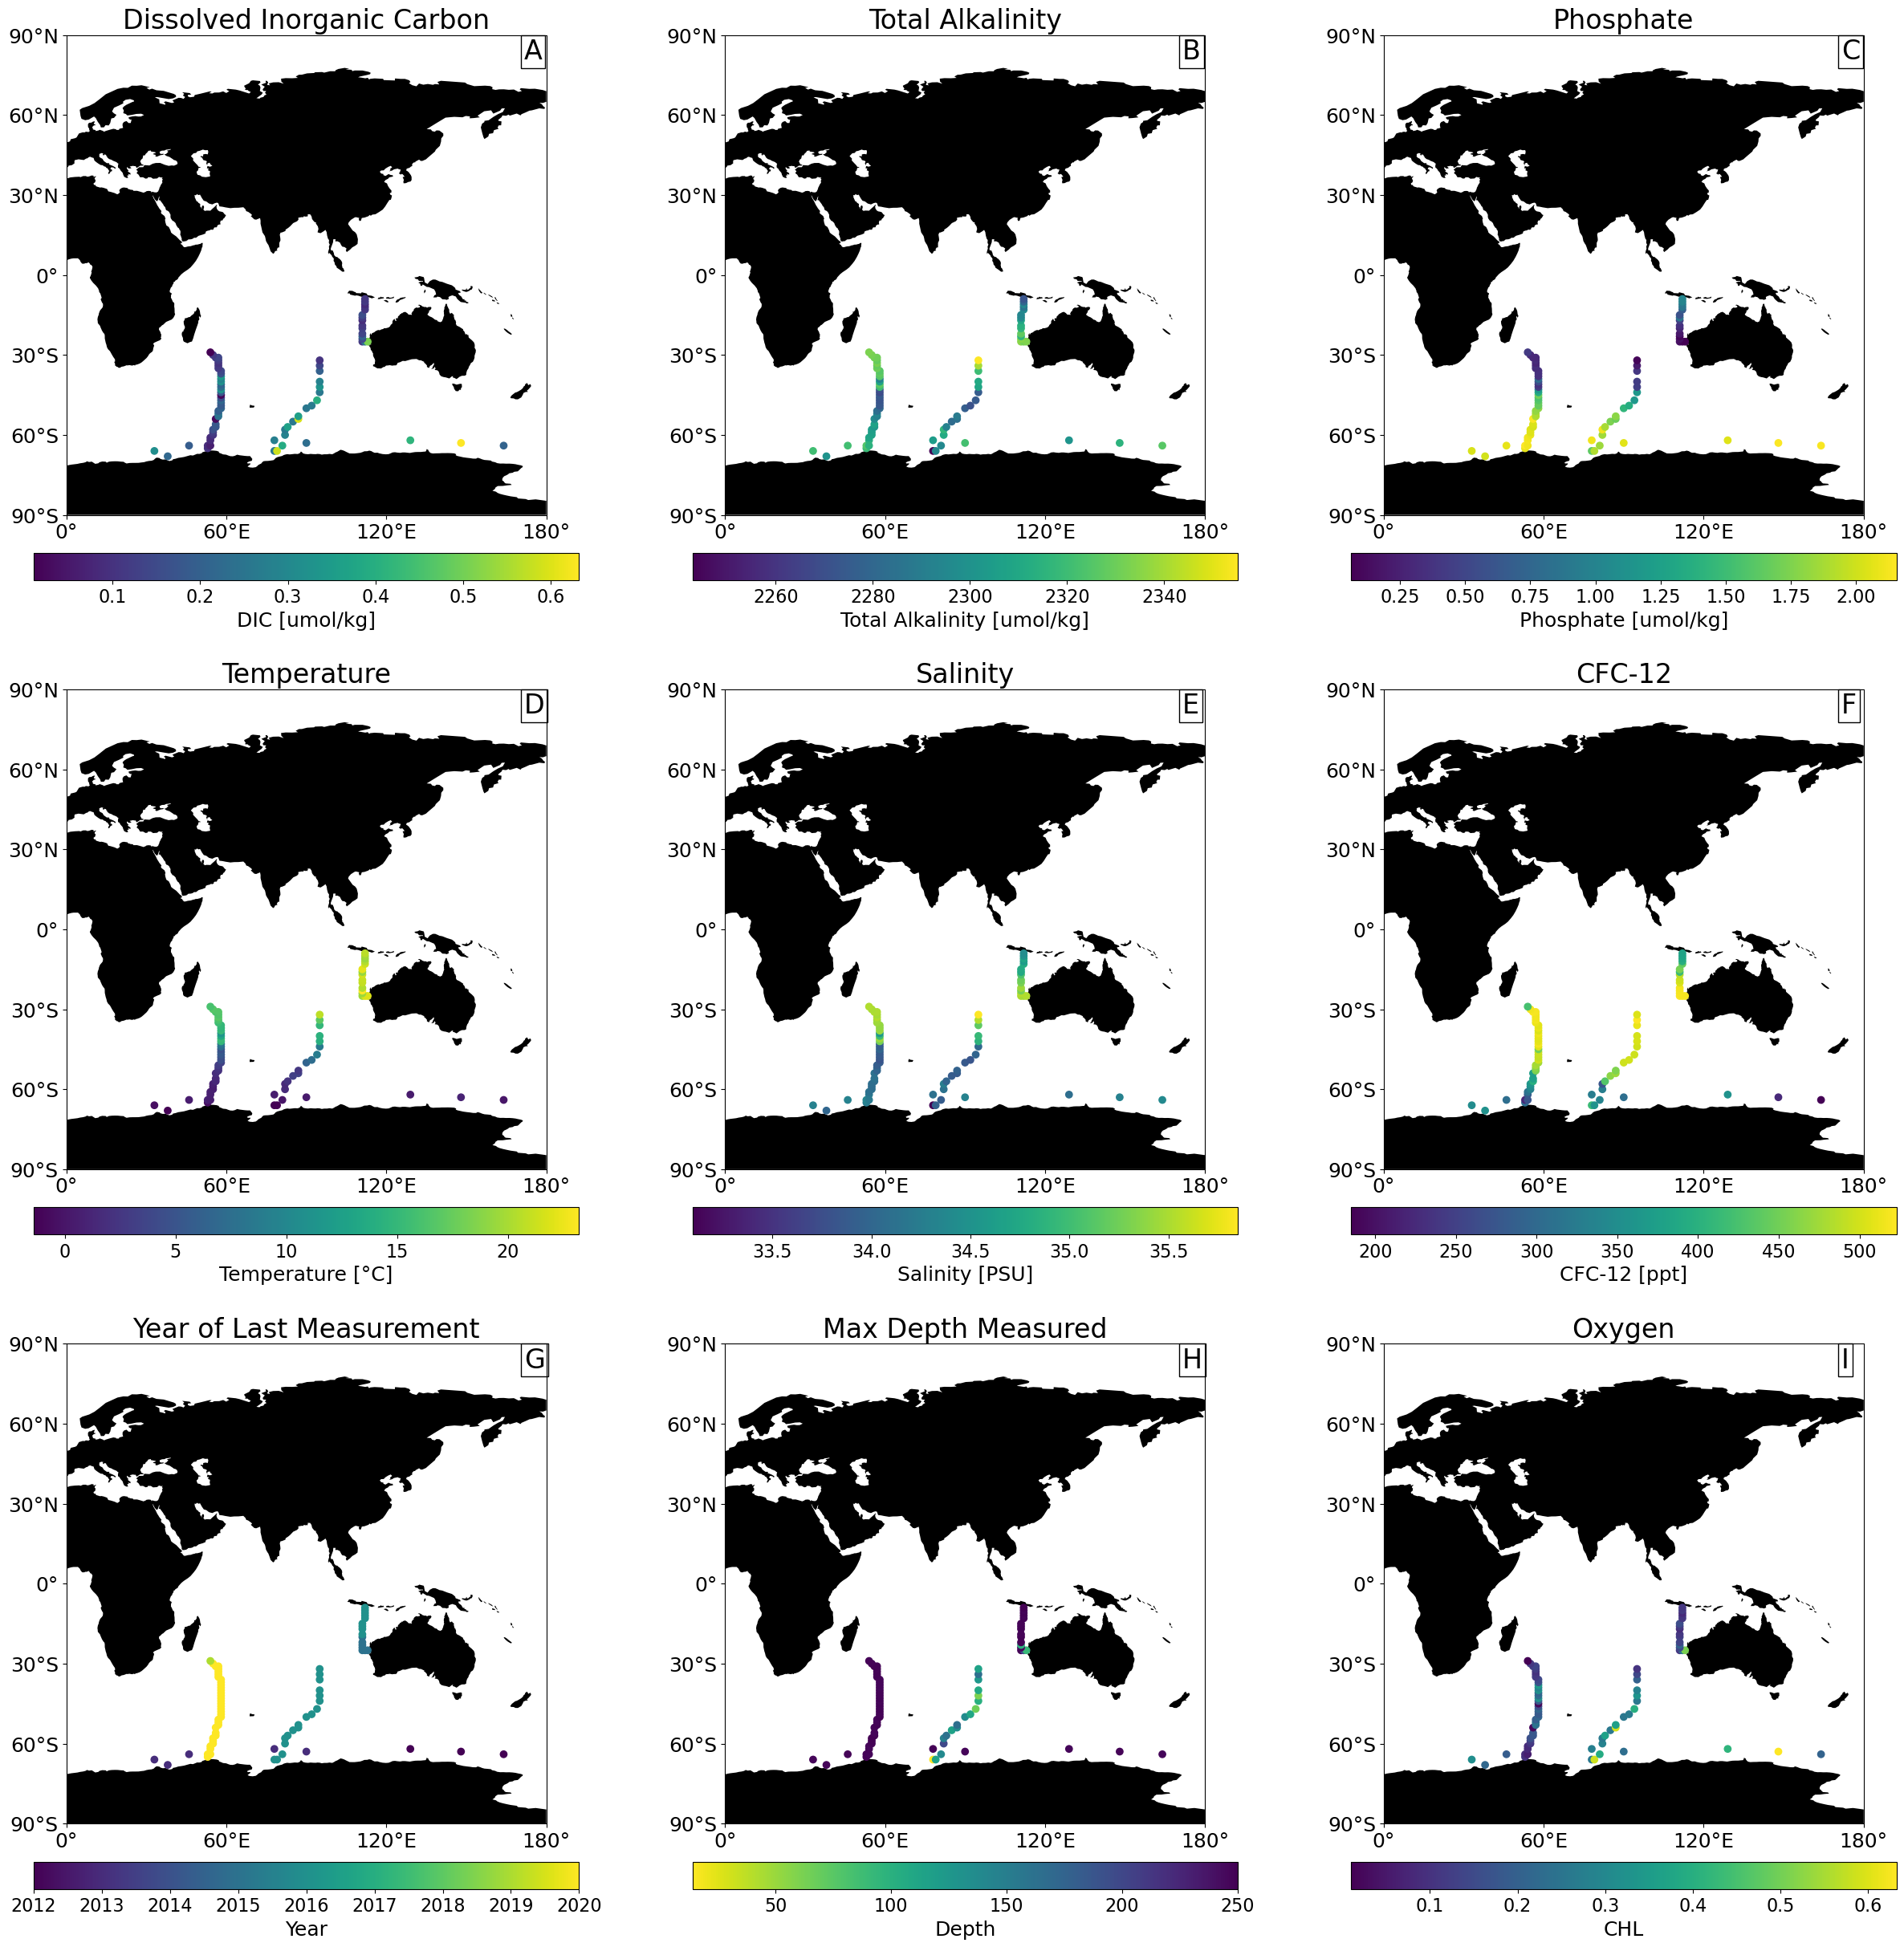

In [140]:
fig, axarr = plt.subplots(nrows = 3, ncols = 3, figsize = [30,30],subplot_kw={'projection':ccrs.PlateCarree()})
import cartopy as cart

axarr = axarr.flatten()

ax = axarr[0]
C = df['CHL']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('DIC [umol/kg]', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('Dissolved Inorganic Carbon', fontsize = 24)

ax = axarr[1]
C = df['TA']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Total Alkalinity [umol/kg]', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('Total Alkalinity', fontsize = 24)

ax = axarr[2]
C = df['PO4']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Phosphate [umol/kg]', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('Phosphate', fontsize = 24)

ax = axarr[3]
C = df['temperature']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Temperature [°C]', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('Temperature', fontsize = 24)

ax = axarr[4]
C = df['salinity']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Salinity [PSU]', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('Salinity', fontsize = 24)

ax = axarr[5]
C = df['CFC12']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('CFC-12 [ppt]', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('CFC-12', fontsize = 24)

ax = axarr[6]
C = dfmax['year']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Year', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('Year of Last Measurement', fontsize = 24)

ax = axarr[7]
C = dfmax['depth']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C, cmap = 'viridis_r')
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('Depth', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('Max Depth Measured', fontsize = 24)

ax = axarr[8]
C = df['CHL']
x,y = np.meshgrid(df['lon'], df['lat'])
im = ax.scatter(df['lon'], df['lat'], c =C)
cbar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.07)
cbar.set_label('CHL', fontsize = 18)
cbar.ax.tick_params(labelsize=16) 
ax.set_title('Oxygen', fontsize = 24)

import matplotlib.transforms as mtransforms
labs = ['A','B','C','D','E','F','G','H','I']
i = 0
for ax in axarr:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.set_xticks(np.arange(0,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # ax.coastlines()
    ax.add_feature(cart.feature.LAND, facecolor='black')
    ax.tick_params('x',labelsize = 18)
    ax.tick_params('y',labelsize = 18)
    lab = labs[i]
    i += 1
    ax.text(0.93, 0.95, lab, transform=ax.transAxes + trans,
            fontsize=24, verticalalignment='bottom', 
            bbox=dict(facecolor='none', edgecolor='k', pad=3.0))
    
# fig.savefig('/Users/akbaskind/Documents/Python Scripts/OCG577/varmap.png', bbox_inches='tight')

In [134]:
df

index        depth        year          DIC  \
latitude longitude                                                        
-69.0    25.0       110019.173913  1488.086957  1996.00000  2246.095652   
         30.0       109963.263158   439.578947  1996.00000  2214.264912   
         32.0        93884.875000   135.750000  2008.00000  2197.712500   
-68.0    25.0       110043.130435  1682.478261  1996.00000  2247.482609   
         30.0       130175.190476  1214.771429  2010.67619  2243.995778   
...                           ...          ...         ...          ...   
 23.0    59.0        63292.500000   268.333333  1995.00000  2209.716667   
         61.0        63083.375000  1085.625000  1995.00000  2288.583333   
 24.0    58.0        63373.000000     5.000000  1995.00000  2025.200000   
         59.0        63289.233333  1170.266667  1995.00000  2280.046667   
         60.0        63162.545455  1345.727273  1995.00000  2276.681818   

                             TA          O2  temperature   salinity       PO4  \
latitude longitude                                                              
-69.0    25.0       2351.482609  242.821739    -0.165652  34.577261  2.163100   
         30.0       2326.092982  279.861404    -0.912189  34.280807  1.997860   
         32.0       2310.095833  308.912500    -1.385296  34.115000  2.021667   
-68.0    25.0       2353.073913  239.256522    -0.055570  34.599870  2.106587   
         30.0       2343.914286  242.310476    -0.054744  34.563119  2.151123   
...                         ...         ...          ...        ...       ...   
 23.0    59.0       2368.916667   48.250000    19.074333  36.203000  1.906667   
         61.0       2384.100000   46.033333    11.769533  35.583583  2.442917   
 24.0    58.0       2414.900000  187.300000    30.801000  36.906000  0.280000   
         59.0       2399.176667   61.276667    12.176077  35.633767  2.319667   
         60.0       2410.827273   75.163636    11.722836  35.585000  2.282727   

                         CFC12  ...      ∆PO4      Cant0        Cant  \
latitude longitude              ...                                    
-69.0    25.0       109.626565  ...  1.933329  55.387693   21.819916   
         30.0       264.912070  ...  1.784428  53.972872   51.781653   
         32.0       390.444583  ...  1.817092  53.169998   60.424601   
-68.0    25.0        95.930652  ...  1.876355  55.526506   19.280505   
         30.0       148.667317  ...  1.922229  55.466622   23.044926   
...                        ...  ...       ...        ...         ...   
 23.0    59.0       247.489667  ...  1.612983  79.022415   78.586321   
         61.0       117.725038  ...  2.155317  70.389260   36.020945   
 24.0    58.0       529.730000  ...  0.064869  90.115951  179.800840   
         59.0       143.373030  ...  2.041162  70.602385   45.590818   
         60.0       126.936609  ...  2.010833  69.816072   41.416293   

                           sDIC  sDICref  sAlkref        dDIC         G   lat  \
latitude longitude                                                              
-69.0    25.0       2224.092498   1909.9  2236.85  314.192498  0.403930 -69.0   
         30.0       2211.486740   1909.9  2236.85  301.586740  0.976095 -69.0   
         32.0       2205.660684   1909.9  2236.85  295.760684  1.140984 -69.0   
-68.0    25.0       2224.036637   1909.9  2236.85  314.136637  0.353466 -68.0   
         30.0       2222.945854   1909.9  2236.85  313.045854  0.423676 -68.0   
...                         ...      ...      ...         ...       ...   ...   
 23.0    59.0       2091.017267   1909.9  2236.85  181.117267  0.932164  23.0   
         61.0       2203.856307   1909.9  2236.85  293.956307  0.443409  23.0   
 24.0    58.0       1878.897875   1909.9  2236.85  -31.002125  1.995217  24.0   
         59.0       2193.811068   1909.9  2236.85  283.911068  0.540011  24.0   
         60.0       2194.035566   1909.9  2236.85  284.135566  0.478104  24.0   

       